# Практическое задание 6
## КМБО-01-20, Гребнев Никита, Большаков Михаил  
## Тема №23 \"Употребление алкоголя учащимися"

In [60]:
import pandas as pd
import numpy as np
df1 = pd.read_csv('student-por.csv')
df2 = pd.read_csv('student-mat.csv')

In [85]:
df = df1.append(df2, ignore_index=True)

In [86]:
df

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1039,MS,M,20,U,LE3,A,2,2,services,services,...,5,5,4,4,5,4,11,9,9,9
1040,MS,M,17,U,LE3,T,3,1,services,services,...,2,4,5,3,4,2,3,14,16,16
1041,MS,M,21,R,GT3,T,1,1,other,other,...,5,5,3,3,3,3,3,10,8,7
1042,MS,M,18,R,LE3,T,3,2,services,other,...,4,4,1,3,4,5,0,11,12,10


# Основное задание: Построить прогноз итогового балла учащегося.

### Насколько сильно влияет употребление алкоголя?

Построим регрессию Итоговой оценки от употребления алкоголя учениками в будние и выходные дни

In [87]:
from sklearn.linear_model import LinearRegression
alc = df.loc[:, df.columns.isin(['Dalc','Walc'])]
y = df.loc[:, df.columns.isin(['G3'])]
model_alc =  LinearRegression().fit(alc,y)
print('G3 =',model_alc.intercept_[0],model_alc.coef_[0][0],"* Dalc",model_alc.coef_[0][1],"* Walc")

G3 = 12.327187348359653 -0.3986734101627845 * Dalc -0.17050443263460502 * Walc


Как видно, для ученика с максимальными показателями употребления алкоголя итоговая оценка (9,47) ниже чем с минимальными (11,75) на 2 балла, отсюда можно сделать вывод, что алкоголь влияет на итоговую оценку не слишком значительно, однако люди, почти не употребляющие алкоголь, в среднем имеют на 1 или 2 балла больше, чем у других.

### Какие параметры вносят наибольший вклад в предсказание?

Нормируем признак (для числовых признаков) через стандартное отклонение:

In [98]:
import math
numeric = ['age', 'absences', 'G1', 'G2', 'G3']
for column in numeric:
    df[column] = (df[column] - df[column].mean())/(math.sqrt(df[column].var()))

Преобразуем текстовые значения в числовые:

In [99]:
texted = ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']
for column in texted:
    cur_set = set(df[column])
    i = 0
    for item in cur_set:
        df[column] = df[column].replace(item, i)
        i = i + 1

In [115]:
y = df.loc[:, df.columns.isin(['G3'])]
x = df.iloc[:,df.columns.isin(['school','sex','age','address','famsize','Pstatus','Medu','Fedu','Mjob','Fjob','reason','guardian','traveltime','studytime','failures','schoolsup','famsup','paid','activities','nursery','higher','internet','romantic','famrel','freetime','goout','Dalc','Walc','health','absences','G1','G2','Dalc','Walc'])]
model = LinearRegression().fit(x,y)
print (model.intercept_, model.coef_)
print ("R^2 =",model.score(x,y), ", модель хорошая")

[-0.03654907] [[-3.24137419e-02  7.89409386e-03 -9.30085943e-03 -2.77743123e-02
  -3.25105032e-03  4.88274501e-02  5.79310978e-03 -1.48386261e-02
   7.81574653e-03 -1.88791986e-02  6.72866577e-03  9.10870662e-03
   3.59753441e-02 -4.90293898e-03 -6.74728565e-02  1.91603286e-02
   5.09077432e-02 -9.05462186e-02 -2.57317649e-02 -2.82200189e-02
   2.48567557e-04  2.40406248e-03 -2.79163190e-02  2.45290174e-02
   9.88604425e-04 -5.02905209e-03 -1.73927620e-02  1.63089163e-02
  -1.79827957e-03  4.73441160e-02  1.02090803e-01  8.14559998e-01]]
R^2 = 0.8404036375568352 , модель хорошая


In [101]:
#оставляю 5 знаков после запятой
a = model.coef_[0]
for i in range(32):
    a[i] = float('{:.5f}'.format(a[i]))

In [116]:
df['G3'].value_counts()

-0.347225    153
-0.088479    151
 0.429013    113
 0.170267    103
 0.687758     90
 0.946504     82
-0.864717     67
-0.605971     63
-2.934684     53
 1.205250     52
 1.463996     35
 1.722742     27
-1.123463     19
-1.382209     18
-1.640954      8
 1.981488      7
 2.240234      1
-2.675938      1
-1.899700      1
Name: G3, dtype: int64

G3 рознится от -2.93468 до 2.24 

In [102]:
print('G3 = ', end='')
for i in range(32):
    print(model.coef_[0][i], end='')
    print('*'+df.columns[i] + ' + ', end='')

G3 = -0.03241*school + 0.00789*sex + -0.0093*age + -0.02777*address + -0.00325*famsize + 0.04883*Pstatus + 0.00579*Medu + -0.01484*Fedu + 0.00782*Mjob + -0.01888*Fjob + 0.00673*reason + 0.00911*guardian + 0.03598*traveltime + -0.0049*studytime + -0.06747*failures + 0.01916*schoolsup + 0.05091*famsup + -0.09055*paid + -0.02573*activities + -0.02822*nursery + 0.00025*higher + 0.0024*internet + -0.02792*romantic + 0.02453*famrel + 0.00099*freetime + -0.00503*goout + -0.01739*Dalc + 0.01631*Walc + -0.0018*health + 0.04734*absences + 0.10209*G1 + 0.81456*G2 + 

Наибольший вклад в предсказание вносят следующие параметры(Если как критерий наибольшего вклада в итоговую оценку взять 
интервал возможных значений больше 0.05):  
  
traveltime: 0.03598 * traveltime ∈ [0.03598,0.14392]  
failures: -0.06747 * failures ∈ [-0.20241, 0]  
famsup: 0.05091 * famsup ∈ [0, 0.05091]  
paid: -0.09055 * paid ∈ [-0.09055, 0]  
Dalc: -0.01739 * Dalc ∈ [-0.08695, -0.01739]  
Walc: 0.01631 * Walc ∈ [0.01631, 0.08155]  
absences: 0.04734 * absences ∈ [0.0338, 0.53792]  
G1: 0.10209 * G1 ∈ [0.010209, 0.051045]  
G2: 0.81456 * G2 ∈ [0.81456, 4.0728]  

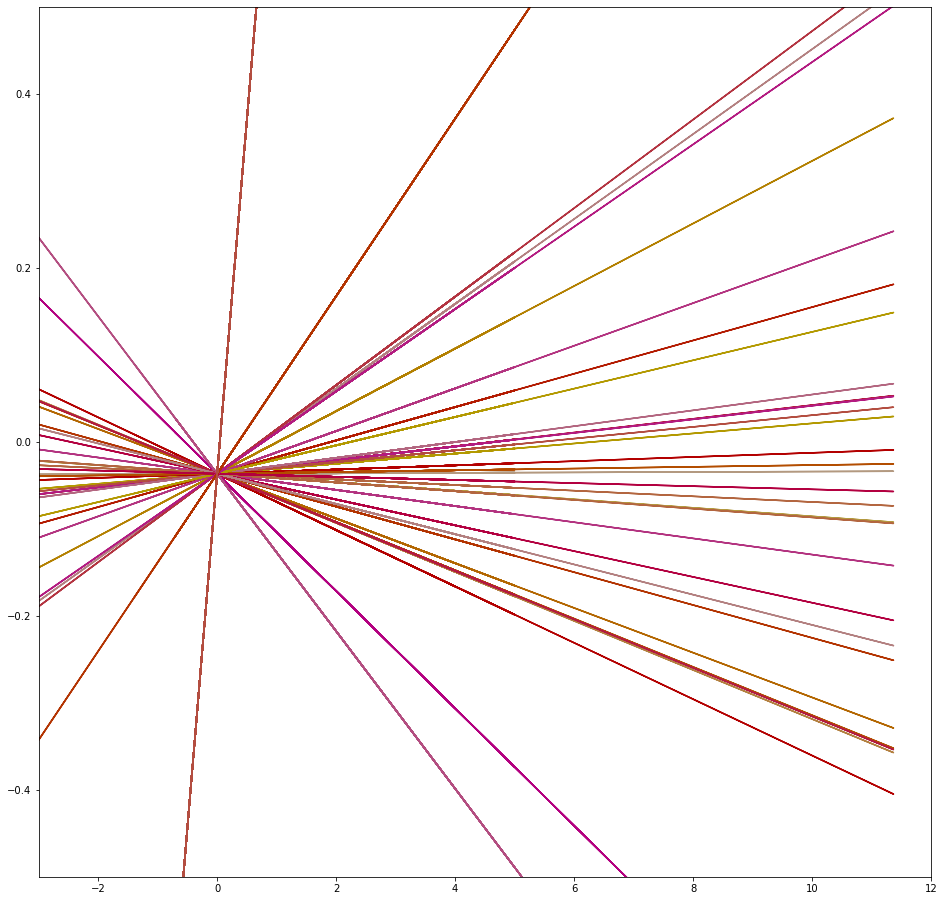

In [147]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 16))
plt.xlim(-3, 12)
plt.ylim(-0.5, 0.5)
for i in range(32):
    plt.plot(x, model.coef_[0][i]*x + model.intercept_[0], color=(0.7,0.1*(i%7),0.25*(i%3)))